#Description
Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.


**[Données](https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_customers_dataset.csv)**


**Votre mission**

Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


To check PEP8 compliance, add codes below:<br>
pip install flake8 pycodestyle_magic<br>
%load_ext pycodestyle_magic

In [ ]:
pip install flake8 pycodestyle_magic

In [76]:
%load_ext pycodestyle_magic

In [2]:
# %%flake8 # PEP8 compliance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import functions as fc
import importlib

pd.set_option("display.max_columns", 1500)
pd.set_option("display.max_rows", 150)
pd.set_option("display.max_colwidth", 150)

# I.Import data

In [3]:
# %%flake8 # PEP8 compliance
dir = './drive/MyDrive/TechnicalLearning/Python/Jupyter/OC_DS_Projets/P5'
path1 = dir+'/data_pc8.ft'
path2 = dir+'/data_noncat_std.ft'
path3 = dir+'/data_RFMLabel.ft'
path4 = dir+'/data_cus.ft'
data_pc8 = pd.read_feather(path1)
data_noncat_std = pd.read_feather(path2)
RFMLabel = pd.read_feather(path3)
data_cus = pd.read_feather(path4)

In [6]:
# %%flake8 # PEP8 compliance
# check mean and std of dataset (prerequisite for kmeans)
data_noncat_std.describe().round(3)

,geolocation_lat,geolocation_lng,Recency,Monetary_log,review_score,payInst_log,credit_card_pct,product_weight_log,product_vol_log,order_item_number
count,93828.000,93828.000,93828.000,93828.000,93828.000,93828.000,93828.000,93828.000,93828.000,93828.000
mean,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,-0.000,0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-2.224,-6.522,-1.579,-4.930,-2.311,-4.019,-1.779,-5.043,-2.927,-0.290
25%,-0.428,-0.477,-0.809,-0.642,-0.067,-0.892,-0.098,-0.752,-0.706,-0.290
50%,-0.310,-0.114,-0.130,0.026,0.682,-0.048,0.575,-0.116,-0.048,-0.290
75%,0.186,0.635,0.712,0.613,0.682,0.824,0.575,0.614,0.758,-0.290
max,11.262,9.251,3.174,5.353,0.682,3.134,0.575,2.933,2.931,36.792


In [8]:
# %%flake8 # PEP8 compliance
# original features, for interpreting customer clusters
data_cus.head(3)

,customer_unique_id,geolocation_lat,geolocation_lng,isSP,Recency,Frequency,Monetary,review_score,payment_installments,credit_card_pct,debit_card_pct,voucher_pct,product_weight_g,product_vol,order_item_number,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,books_technical,cds_dvds_musicals,christmas_supplies,cine_photo,computers,computers_accessories,consoles_games,construction_tools_construction,construction_tools_lights,construction_tools_safety,cool_stuff,costruction_tools_garden,costruction_tools_tools,diapers_and_hygiene,drinks,dvds_blu_ray,electronics,fashio_female_clothing,fashion_bags_accessories,fashion_childrens_clothes,fashion_male_clothing,fashion_shoes,fashion_sport,fashion_underwear_beach,fixed_telephony,flowers,food,food_drink,furniture_bedroom,furniture_decor,furniture_living_room,furniture_mattress_and_upholstery,garden_tools,health_beauty,home_appliances,home_appliances_2,home_comfort_2,home_confort,home_construction,housewares,industry_commerce_and_business,kitchen_dining_laundry_garden_furniture,la_cuisine,luggage_accessories,market_place,music,musical_instruments,office_furniture,party_supplies,perfumery,pet_shop,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
0,0000366f3b9a7992bf8c76cfdf3221e2,-23.337679,-46.826739,1,116,1,129.9,5.0,8.0,1.0,0.0,0.0,1500.0,7616.0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,-23.557876,-46.788754,1,119,1,18.9,4.0,1.0,1.0,0.0,0.0,375.0,5148.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0000f46a3911fa3c0805444483337064,-27.543787,-48.631973,0,542,1,69.0,3.0,8.0,1.0,0.0,0.0,1500.0,43750.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [4]:
# %%flake8 # PEP8 compliance
var_cus = [
           'geolocation_lat', 'geolocation_lng', 'Recency', 'Monetary',
           'review_score', 'payment_installments', 'credit_card_pct',
           'product_weight_g', 'product_vol', 'order_item_number']
data_noncat = data_cus[var_cus]
data_noncat.head(3)

,geolocation_lat,geolocation_lng,Recency,Monetary,review_score,payment_installments,credit_card_pct,product_weight_g,product_vol,order_item_number
0,-23.337679,-46.826739,116,129.9,5.0,8.0,1.0,1500.0,7616.0,1
1,-23.557876,-46.788754,119,18.9,4.0,1.0,1.0,375.0,5148.0,1
2,-27.543787,-48.631973,542,69.0,3.0,8.0,1.0,1500.0,43750.0,1


After learning with data_noncat_std, I found a cluster which only differ from others in geolocation, while other features (RFM, review, etc.) of this cluster are at an average level. It useless for marketing when we can't find cluster's shopping patterns. So we decide to delete geolocaiton in order to focus on shopping patterns.

In [5]:
# %%flake8 # PEP8 compliance
# only focus on features that describe shopping patterns
X_std = data_noncat_std.drop(columns=['geolocation_lat', 'geolocation_lng'])
X_std.head(3)

,Recency,Monetary_log,review_score,payInst_log,credit_card_pct,product_weight_log,product_vol_log,order_item_number
0,-0.828522,0.418907,0.681521,1.711972,0.57494,0.456202,0.062296,-0.290367
1,-0.808935,-1.631363,-0.066730,-0.891621,0.57494,-0.584678,-0.244636,-0.290367
2,1.952853,-0.254012,-0.814982,1.711972,0.57494,0.456202,1.432396,-0.290367


In [9]:
def pca_ScreePlot(ratio, i=90):
    plt.bar(np.arange(len(ratio)) + 1, ratio * 100)
    plt.plot(np.arange(len(ratio)) + 1, ratio.cumsum() * 100, 'r-o')
    plt.plot((1, len(ratio) + 1), (i, i), 'r--')
    plt.grid()
    plt.title('Scree Plot')
    plt.xlabel('Number of principal components')
    plt.ylabel('Percentage explained variance')

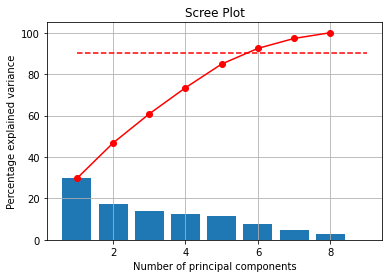

In [10]:
pca = PCA()
pca.fit(X_std)
pca_ScreePlot(pca.explained_variance_ratio_)

In [6]:
# %%flake8 # PEP8 compliance
# keep components explaining at least 90% of variance of data
pca = PCA(n_components=0.9)
X_pc = pca.fit_transform(X_std)
pca.explained_variance_ratio_.cumsum()

array([0.29603286, 0.46725306, 0.60802221, 0.73435015, 0.84891174,
       0.92442804])

#II. KMeans

## II.i  Optimal K

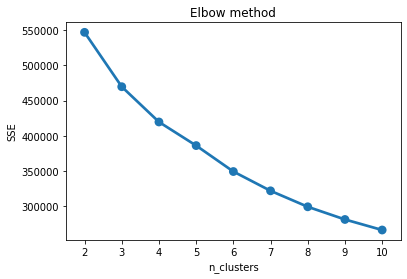

In [8]:
# %%flake8 # PEP8 compliance
# method 1: Elbow method with X_pc
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pc)
    sse[k] = kmeans.inertia_
ax = sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
ax.set(xlabel='n_clusters', ylabel='SSE', title='Elbow method')
plt.show()

The residual sum of squares decrease by increasing K. The optimal K is at elbow of curve.
Here the elbow is not evident.

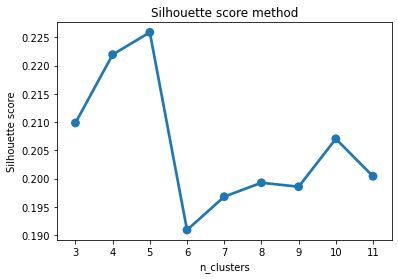

In [9]:
# %%flake8 # PEP8 compliance
# method 2: silhouette_score with X_pc
silt_score = {}
for k in range(3, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_pc)
    silt_score[k] = silhouette_score(
        X_pc, kmeans.labels_, random_state=42, sample_size=10000)
ax = sns.pointplot(x=list(silt_score.keys()), y=list(silt_score.values()))
ax.set(xlabel='n_clusters', ylabel='Silhouette score',
       title='Silhouette score method')
plt.show()

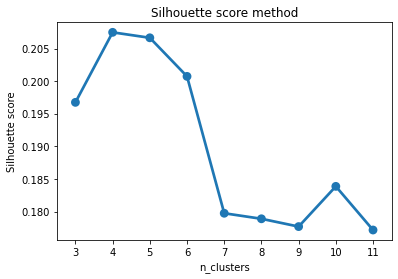

In [10]:
# %%flake8 # PEP8 compliance
# method 2: silhouette_score with X_std
silt_score = {}
for k in range(3, 12):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_std)
    silt_score[k] = silhouette_score(
        X_std, kmeans.labels_, random_state=42, sample_size=10000)
ax = sns.pointplot(x=list(silt_score.keys()), y=list(silt_score.values()))
ax.set(xlabel='n_clusters', ylabel='Silhouette score',
       title='Silhouette score method')
plt.show()

In [37]:
# %%flake8 # PEP8 compliance
# comparing clustering result of X_std and X_pc
ARI = {}
for i in [4, 5]:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_std)
    cluster_data = kmeans.labels_
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pc)
    cluster_pc = kmeans.labels_
    ARI[i] = adjusted_rand_score(cluster_pc, cluster_data)
ARI

{4: 0.9629125099345148, 5: 0.5278783275431116}

Both X_std and X_pc have a decent score at **4** and **5** clusters.
Clustering result is more stable when n_cluster = 4. so we'll choose **n_cluster=4**. We'll use X_pc in latter learning in order to save computing resources.

##II.ii modeling and visualization


In [45]:
# %%flake8 # PEP8 compliance
# fitting with principal components
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_pc)
cluster_K = kmeans.labels_
gini_K = fc.gini(cluster_K)
score_K = silhouette_score(X_pc, cluster_K)
print('Gini coefficient: {:.2f}, \
Silhouette score: {:.4f}'.format(gini_K, score_K))

Gini coefficient: 0.30, Silhouette score: 0.2216


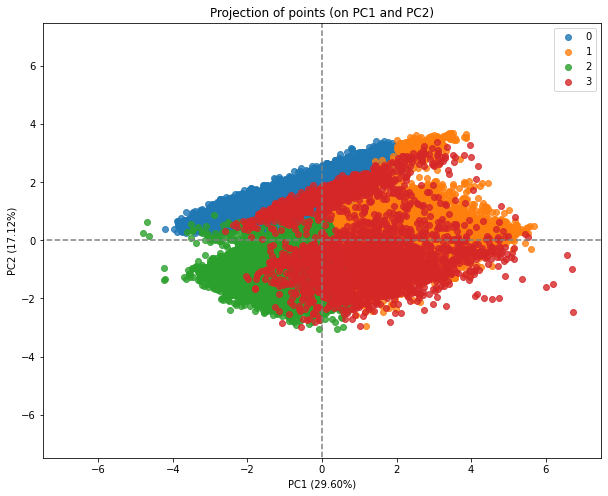

In [48]:
# %%flake8 # PEP8 compliance
# display clusters distribution on factorial plane of PC1 and PC2
fc.display_factorial_planes(X_pc, pca, [(0, 1)], illustrative_var=cluster_K)

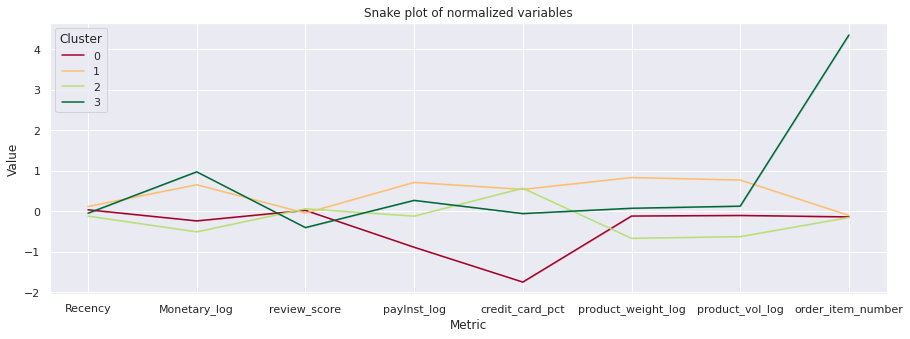

In [50]:
# %%flake8 # PEP8 compliance
# snake plot comparing features of different clusters
fc.snake_plot(X_std, cluster_K)

The snake plot gives a global view by comparing features of each clusters, such as:<br>
Cluster 0 don't use credit card, Cluster 3 give critical reviews but buy a lot.<br>
We'll present full features of each cluster, in order to find some latent traits such as favorite product category. 

In [54]:
# %%flake8 # PEP8 compliance
# observe a cluster under all its features
data_K = data_cus.assign(Cluster=cluster_K)
gp = data_K.groupby('Cluster')
df = gp.mean().round(3)
# verify cluster's size
df.insert(0, 'size', gp.size())
df

,size,geolocation_lat,geolocation_lng,isSP,Recency,Frequency,Monetary,review_score,payment_installments,credit_card_pct,debit_card_pct,voucher_pct,product_weight_g,product_vol,order_item_number,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,books_technical,cds_dvds_musicals,christmas_supplies,cine_photo,computers,computers_accessories,consoles_games,construction_tools_construction,construction_tools_lights,construction_tools_safety,cool_stuff,costruction_tools_garden,costruction_tools_tools,diapers_and_hygiene,drinks,dvds_blu_ray,electronics,fashio_female_clothing,fashion_bags_accessories,fashion_childrens_clothes,fashion_male_clothing,fashion_shoes,fashion_sport,fashion_underwear_beach,fixed_telephony,flowers,food,food_drink,furniture_bedroom,furniture_decor,furniture_living_room,furniture_mattress_and_upholstery,garden_tools,health_beauty,home_appliances,home_appliances_2,home_comfort_2,home_confort,home_construction,housewares,industry_commerce_and_business,kitchen_dining_laundry_garden_furniture,la_cuisine,luggage_accessories,market_place,music,musical_instruments,office_furniture,party_supplies,perfumery,pet_shop,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,21811,-21.307,-46.425,0.421,248.263,1.021,104.793,4.117,1.004,0.013,0.064,0.111,1653.686,12604.241,1.093,0.003,0.003,0.0,0.005,0.043,0.028,0.095,0.006,0.001,0.003,0.0,0.001,0.001,0.001,0.095,0.013,0.007,0.003,0.002,0.037,0.002,0.001,0.000,0.003,0.001,0.034,0.001,0.024,0.0,0.001,0.002,0.000,0.002,0.003,0.000,0.006,0.003,0.001,0.076,0.004,0.000,0.046,0.094,0.007,0.002,0.000,0.004,0.004,0.061,0.003,0.003,0.0,0.009,0.004,0.0,0.007,0.016,0.001,0.033,0.019,0.0,0.002,0.006,0.000,0.088,0.024,0.001,0.053,0.038,0.052
1,32492,-21.023,-46.015,0.389,260.736,1.031,231.415,4.027,4.695,0.984,0.001,0.005,4310.204,29084.870,1.116,0.004,0.003,0.0,0.003,0.050,0.038,0.154,0.003,0.000,0.001,0.0,0.001,0.001,0.005,0.034,0.006,0.010,0.003,0.001,0.064,0.002,0.001,0.000,0.001,0.000,0.008,0.000,0.005,0.0,0.001,0.003,0.000,0.000,0.001,0.000,0.001,0.001,0.002,0.097,0.009,0.001,0.062,0.072,0.005,0.005,0.000,0.009,0.008,0.085,0.005,0.005,0.0,0.020,0.002,0.0,0.009,0.030,0.000,0.024,0.023,0.0,0.001,0.010,0.002,0.085,0.034,0.000,0.007,0.053,0.039
2,36742,-21.212,-46.129,0.445,224.522,1.017,72.815,4.168,2.395,0.996,0.000,0.003,452.304,4696.240,1.084,0.002,0.001,0.0,0.004,0.038,0.029,0.071,0.008,0.001,0.004,0.0,0.001,0.001,0.000,0.100,0.017,0.007,0.002,0.002,0.021,0.002,0.001,0.000,0.005,0.001,0.044,0.000,0.032,0.0,0.001,0.002,0.000,0.002,0.003,0.001,0.008,0.004,0.000,0.047,0.001,0.000,0.018,0.127,0.011,0.000,0.000,0.001,0.004,0.052,0.000,0.001,0.0,0.005,0.003,0.0,0.005,0.000,0.000,0.047,0.017,0.0,0.001,0.006,0.000,0.088,0.021,0.002,0.080,0.037,0.088
3,2783,-21.517,-46.453,0.440,235.191,1.411,323.107,3.549,3.731,0.731,0.011,0.022,2009.559,15415.495,3.875,0.008,0.003,0.0,0.003,0.095,0.055,0.502,0.010,0.000,0.001,0.0,0.008,0.003,0.007,0.339,0.015,0.065,0.023,0.011,0.052,0.010,0.001,0.005,0.032,0.002,0.056,0.003,0.066,0.0,0.006,0.005,0.002,0.002,0.014,0.000,0.021,0.017,0.005,0.641,0.029,0.000,0.238,0.211,0.012,0.002,0.001,0.015,0.038,0.343,0.008,0.006,0.0,0.014,0.010,0.0,0.014,0.135,0.000,0.056,0.061,0.0,0.019,0.010,0.000,0.258,0.043,0.001,0.070,0.063,0.117


# III. DBSCAN

##III.i Optimal eps and min_samples
In order to save computation resource, we'll use a 10% sample of X_pc to do the training. We'll only compute silhouette score for wanted clusters (3 < n_cluster < 9), since too few or too many clusters are not very meaningful for marketing.

In [21]:
# %%flake8 # PEP8 compliance
# search in a wide range of eps=(0,4) , n=(4,65)
# gradually narrow down to 2 zones as below
X = pd.DataFrame(X_pc).sample(frac=0.1, random_state=42)
param_grid = [
              {'eps': np.linspace(0.9, 1, 2),
               'min_samples': np.arange(45, 55)},
              {'eps': np.linspace(1.5, 1.7, 3),
               'min_samples': np.arange(5, 10)}]
grid = ParameterGrid(param_grid)

In [22]:
# %%flake8 # PEP8 compliance
# search optimal parameters by comparing n_clus, silhouette score and gini
params_db = []
score_db = []
n_clus_db = []
gini_db = []
for params in grid:
    dbscan = DBSCAN(**params, n_jobs=-1)
    dbscan.fit(X)
    n_clus = len(np.unique(dbscan.labels_))
    if (n_clus > 3) & (n_clus < 9):
        score_db.append(silhouette_score(X, dbscan.labels_))
        n_clus_db.append(n_clus)
        gini_db.append(fc.gini(dbscan.labels_))
        params_db.append(params)
    # NaN score/gini for unwanted number of cluster
    else:
        score_db.append(np.nan)
        n_clus_db.append(n_clus)
        gini_db.append(np.nan)
        params_db.append(params)

# display n_cluster and score under the corresponding parameters
results_db = pd.DataFrame({
    'score': score_db, 'gini': gini_db,
    'n_clus': n_clus_db, 'parameters': params_db})
results_db.sort_values('score', ascending=False)

,score,gini,n_clus,parameters
31,0.351458,0.795140,5,"{'eps': 1.7, 'min_samples': 6}"
25,0.283778,0.743232,4,"{'eps': 1.6, 'min_samples': 5}"
29,0.228222,0.791176,5,"{'eps': 1.6, 'min_samples': 9}"
21,0.189750,0.776894,5,"{'eps': 1.5, 'min_samples': 6}"
22,0.188254,0.777193,5,"{'eps': 1.5, 'min_samples': 7}"
20,0.182578,0.838720,7,"{'eps': 1.5, 'min_samples': 5}"
23,0.178216,0.779921,5,"{'eps': 1.5, 'min_samples': 8}"
24,0.175676,0.780475,5,"{'eps': 1.5, 'min_samples': 9}"
13,0.146853,0.402084,4,"{'eps': 1.0, 'min_samples': 48}"
14,0.144599,0.394677,4,"{'eps': 1.0, 'min_samples': 49}"


##III.ii modeling and visualization

### best score parameters

In [23]:
# %%flake8 # PEP8 compliance
# fitting with best score parameters
i = np.nanargmax(score_db)
dbscan = DBSCAN(**params_db[i])
dbscan.fit(X)
print('DBSCAN:\nbest score: {:.4f},\ngini coefficient: {:.2f}\n\
number of clusters: {}, \nbest parameter: {}'.format(
    score_db[i], gini_db[i], n_clus_db[i], params_db[i]))

DBSCAN:
best score: 0.3515,
gini coefficient: 0.80
number of clusters: 5, 
best parameter: {'eps': 1.7, 'min_samples': 6}


DBSCAN cluster labels:[-1  0  1  2  3]
cluster size:[  78 9292    6    3    4]


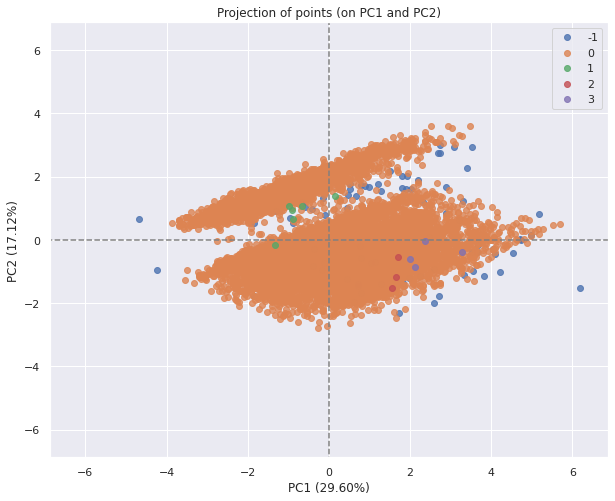

In [75]:
# %%flake8 # PEP8 compliance
# cluster size is extremely unbalanced
a, b = np.unique(dbscan.labels_, return_counts=True)
print('DBSCAN cluster labels:{}\ncluster size:{}'.format(a, b))
fc.display_factorial_planes(
    X.values, pca, [(0, 1)], illustrative_var=dbscan.labels_)

### balanced parameters
We can sacrafice a part of silhouette score for a more balanced clustering, which is more interpretable.

In [24]:
# %%flake8 # PEP8 compliance
# checking manuelly the results_db, choose the best score with gini acceptable
i = 13
dbscan = DBSCAN(**params_db[i])
dbscan.fit(X)
print('DBSCAN:\nbest score: {:.4f},\ngini coefficient: {:.2f}\n\
number of clusters: {}, \nbest parameter: {}'.format(
    score_db[i], gini_db[i], n_clus_db[i], params_db[i]))

DBSCAN:
best score: 0.1469,
gini coefficient: 0.40
number of clusters: 4, 
best parameter: {'eps': 1.0, 'min_samples': 48}


DBSCAN cluster labels:[-1  0  1  2]
cluster size:[2017 5291  362 1713]


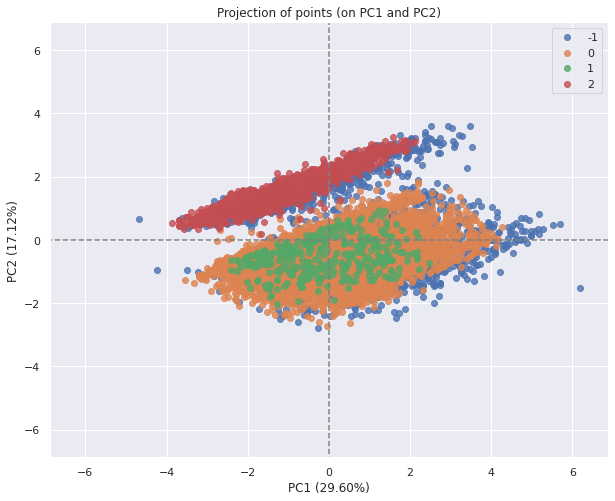

In [80]:
# %%flake8 # PEP8 compliance
# cluster size is extremely unbalanced
a, b = np.unique(dbscan.labels_, return_counts=True)
print('DBSCAN cluster labels:{}\ncluster size:{}'.format(a, b))
fc.display_factorial_planes(
    X.values, pca, [(0, 1)], illustrative_var=dbscan.labels_)

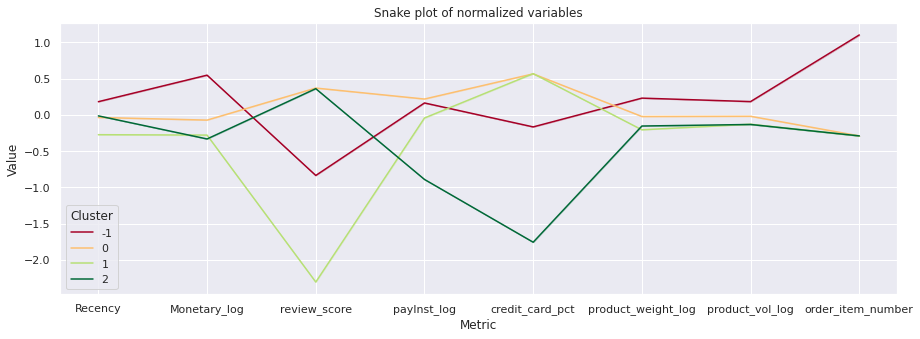

In [25]:
# %%flake8 # PEP8 compliance
# snake plot comparing features of different clusters
X_std_s = pd.DataFrame(X_std).sample(frac=0.1, random_state=42)
fc.snake_plot(X_std_s, dbscan.labels_)

In [85]:
# %%flake8 # PEP8 compliance
# observe a cluster under all its features
data_db = data_cus.sample(frac=0.1, random_state=42).assign(
    Cluster=dbscan.labels_)
gp = data_db.groupby('Cluster')
df = gp.mean().round(3)
# verify cluster's size
df.insert(0, 'size', gp.size())
df

,size,geolocation_lat,geolocation_lng,isSP,Recency,Frequency,Monetary,review_score,payment_installments,credit_card_pct,debit_card_pct,voucher_pct,product_weight_g,product_vol,order_item_number,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,books_technical,cds_dvds_musicals,christmas_supplies,cine_photo,computers,computers_accessories,consoles_games,construction_tools_construction,construction_tools_lights,construction_tools_safety,cool_stuff,costruction_tools_garden,costruction_tools_tools,diapers_and_hygiene,drinks,dvds_blu_ray,electronics,fashio_female_clothing,fashion_bags_accessories,fashion_childrens_clothes,fashion_male_clothing,fashion_shoes,fashion_sport,fashion_underwear_beach,fixed_telephony,flowers,food,food_drink,furniture_bedroom,furniture_decor,furniture_living_room,furniture_mattress_and_upholstery,garden_tools,health_beauty,home_appliances,home_appliances_2,home_comfort_2,home_confort,home_construction,housewares,industry_commerce_and_business,kitchen_dining_laundry_garden_furniture,la_cuisine,luggage_accessories,market_place,music,musical_instruments,office_furniture,party_supplies,perfumery,pet_shop,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,2017,-20.960,-46.165,0.403,270.768,1.151,273.617,2.971,3.485,0.685,0.014,0.037,3213.248,22042.952,1.864,0.005,0.001,0.000,0.007,0.077,0.048,0.238,0.009,0.000,0.000,0.001,0.003,0.001,0.009,0.115,0.012,0.015,0.004,0.000,0.044,0.009,0.001,0.0,0.005,0.0,0.030,0.0,0.030,0.0,0.003,0.003,0.0,0.004,0.011,0.0,0.006,0.008,0.003,0.237,0.008,0.000,0.072,0.117,0.012,0.004,0.0,0.008,0.013,0.146,0.004,0.006,0.0,0.011,0.009,0.001,0.011,0.056,0.000,0.043,0.034,0.0,0.004,0.015,0.002,0.133,0.025,0.001,0.059,0.046,0.069
0,5291,-21.173,-46.165,0.434,237.413,1.000,118.799,4.584,3.319,0.996,0.000,0.004,1940.287,14441.096,1.000,0.002,0.002,0.001,0.004,0.046,0.029,0.095,0.007,0.000,0.004,0.000,0.001,0.000,0.000,0.065,0.012,0.005,0.002,0.002,0.046,0.002,0.000,0.0,0.002,0.0,0.026,0.0,0.018,0.0,0.001,0.003,0.0,0.002,0.001,0.0,0.004,0.001,0.001,0.053,0.005,0.001,0.035,0.100,0.010,0.002,0.0,0.003,0.005,0.056,0.002,0.002,0.0,0.012,0.003,0.000,0.006,0.009,0.001,0.035,0.019,0.0,0.001,0.005,0.001,0.076,0.027,0.001,0.040,0.045,0.063
1,362,-20.503,-45.557,0.318,200.983,1.000,84.736,1.006,2.533,0.997,0.000,0.003,1123.392,9636.169,1.000,0.000,0.006,0.000,0.006,0.041,0.014,0.122,0.008,0.000,0.003,0.000,0.000,0.000,0.000,0.072,0.011,0.008,0.000,0.000,0.022,0.003,0.000,0.0,0.006,0.0,0.058,0.0,0.014,0.0,0.000,0.000,0.0,0.000,0.006,0.0,0.006,0.000,0.000,0.039,0.000,0.000,0.019,0.110,0.006,0.000,0.0,0.006,0.006,0.047,0.003,0.003,0.0,0.008,0.003,0.000,0.003,0.000,0.000,0.033,0.014,0.0,0.000,0.003,0.000,0.088,0.041,0.000,0.055,0.061,0.047
2,1713,-21.396,-46.648,0.435,240.771,1.000,86.834,4.572,1.000,0.009,0.072,0.112,1510.800,11484.295,1.000,0.002,0.002,0.000,0.006,0.041,0.030,0.082,0.005,0.001,0.001,0.000,0.002,0.001,0.000,0.088,0.013,0.005,0.001,0.002,0.040,0.002,0.002,0.0,0.003,0.0,0.032,0.0,0.025,0.0,0.002,0.001,0.0,0.001,0.001,0.0,0.007,0.002,0.001,0.055,0.004,0.000,0.045,0.093,0.006,0.002,0.0,0.002,0.002,0.052,0.003,0.001,0.0,0.013,0.004,0.000,0.007,0.011,0.000,0.033,0.020,0.0,0.003,0.005,0.001,0.082,0.023,0.001,0.046,0.039,0.046


Interpretation: <br>
cluster -1: include all customers who purchase at least 2 items. High spending power, tend to buy heavy and voluminous items.<br>
cluster 0: 1-item, medium spending power, tend to pay by credit card and installments, being positive in reviews.<br>
cluster 1: 1-item, low spending power, tend to buy small items and pay by credit card, being critical in reviews.<br>
cluster 2: 1-item, low spending power, no credit card, likely to be stimulated by vouchers.

# IV. Hierarchical Clustering

##IV.i Optimal n_clusters, affinity, linkage

In [16]:
# %%flake8 # PEP8 compliance
# combination of parameters
X = pd.DataFrame(X_pc).sample(frac=0.1, random_state=42)
param_grid = [
              {'n_clusters': np.arange(4, 10),
               'affinity': ['euclidean', 'manhattan', 'cosine'],
               'linkage': ['complete', 'average', 'single']},
              {'n_clusters': np.arange(4, 10),
               'linkage': ['ward']}]
grid = ParameterGrid(param_grid)

In [17]:
# %%flake8 # PEP8 compliance
# fitting with grid search
score_H = []
params_H = []
gini_H = []
for params in grid:
    hiera = AgglomerativeClustering(**params).fit(X)
    score_H.append(silhouette_score(X, hiera.labels_))
    params_H.append(params)
    gini_H.append(fc.gini(hiera.labels_))

results_H = pd.DataFrame(
    {'score': score_H, 'gini': gini_H, 'parameters': params_H})
results_H.sort_values('score', ascending=False)

,score,gini,parameters
30,0.797018,0.749627,"{'affinity': 'manhattan', 'linkage': 'single', 'n_clusters': 4}"
12,0.797018,0.749627,"{'affinity': 'euclidean', 'linkage': 'single', 'n_clusters': 4}"
31,0.776325,0.799574,"{'affinity': 'manhattan', 'linkage': 'single', 'n_clusters': 5}"
13,0.776325,0.799574,"{'affinity': 'euclidean', 'linkage': 'single', 'n_clusters': 5}"
15,0.707168,0.856503,"{'affinity': 'euclidean', 'linkage': 'single', 'n_clusters': 7}"
32,0.707026,0.832800,"{'affinity': 'manhattan', 'linkage': 'single', 'n_clusters': 6}"
14,0.707026,0.832800,"{'affinity': 'euclidean', 'linkage': 'single', 'n_clusters': 6}"
16,0.658765,0.874254,"{'affinity': 'euclidean', 'linkage': 'single', 'n_clusters': 8}"
33,0.658585,0.856503,"{'affinity': 'manhattan', 'linkage': 'single', 'n_clusters': 7}"
18,0.650908,0.748561,"{'affinity': 'manhattan', 'linkage': 'complete', 'n_clusters': 4}"


##IV.ii modeling and visualization

###best score parameters

In [97]:
# %%flake8 # PEP8 compliance
# fitting with best score parameters
i = np.nanargmax(score_H)
hiera = AgglomerativeClustering(**params_H[i])
hiera.fit(X)
print('best score: {:.4f},\ngini coefficien: {:.2f}, \
\ntbest parameter: {}'.format(score_H[i], gini_H[i], params_H[i]))

best score: 0.7970,
gini coefficien: 0.75, 
tbest parameter: {'affinity': 'euclidean', 'linkage': 'single', 'n_clusters': 4}


The size of clusters is extremely unbalanced. It's meaningless when there is only one or two customers in a cluster.

Hierachical cluster labels:[0 1 2 3]
cluster size:[   2 9379    1    1]


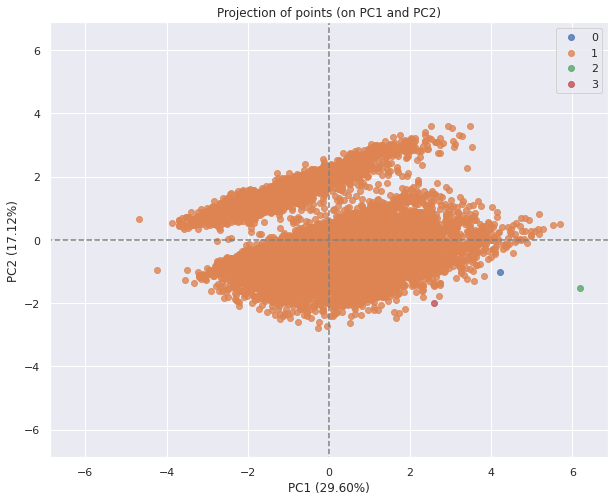

In [101]:
# %%flake8 # PEP8 compliance
# show clusters' size and display it on factorial plane
a, b = np.unique(hiera.labels_, return_counts=True)
print('Hierachical cluster labels:{}\ncluster size:{}'.format(a, b))
fc.display_factorial_planes(
    X.values, pca, [(0, 1)], illustrative_var=hiera.labels_)

###balanced parameters
We sacrifice a part of silhouette score for a more size-balanced clustering

In [103]:
# %%flake8 # PEP8 compliance
# checking manually results_H, choose the best score when gini is acceptable
i = 42
hiera = AgglomerativeClustering(**params_H[i])
hiera.fit(X)
print('best score: {:.4f},\ngini coefficien: {:.2f}, \
\ntbest parameter: {}'.format(score_H[i], gini_H[i], params_H[i]))

best score: 0.1785,
gini coefficien: 0.16, 
tbest parameter: {'affinity': 'cosine', 'linkage': 'average', 'n_clusters': 4}


Hierachical cluster labels:[0 1 2 3]
cluster size:[3149 1236 2684 2314]


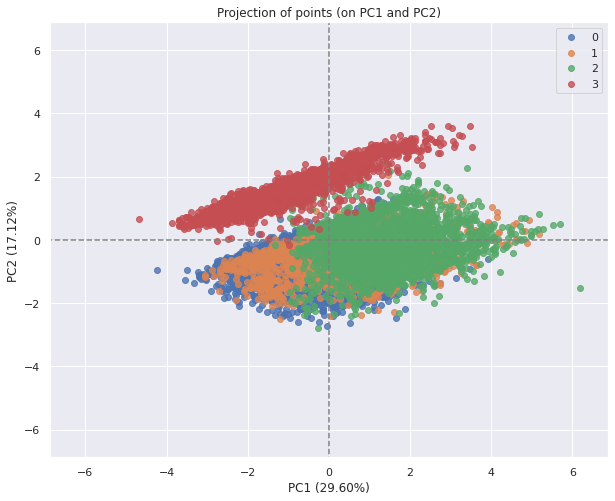

In [106]:
# %%flake8 # PEP8 compliance
# show clusters' size and display it on factorial plane
a, b = np.unique(hiera.labels_, return_counts=True)
print('Hierachical cluster labels:{}\ncluster size:{}'.format(a, b))
fc.display_factorial_planes(
    X.values, pca, [(0, 1)], illustrative_var=hiera.labels_)

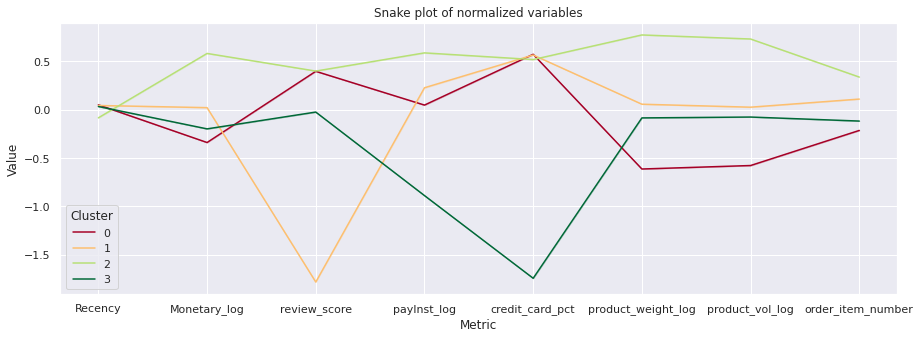

In [108]:
# %%flake8 # PEP8 compliance
# snake plot of Hierachical clustering
X_std_s = pd.DataFrame(X_std).sample(frac=0.1, random_state=42)
fc.snake_plot(X_std_s, hiera.labels_)

In [111]:
# %%flake8 # PEP8 compliance
# observe a cluster under all its features
data_H = data_cus.sample(frac=0.1, random_state=42).assign(
    Cluster=hiera.labels_)
gp = data_H.groupby('Cluster')
df = gp.mean().round(3)
# verify cluster's size
df.insert(0, 'size', gp.size())
df

,size,geolocation_lat,geolocation_lng,isSP,Recency,Frequency,Monetary,review_score,payment_installments,credit_card_pct,debit_card_pct,voucher_pct,product_weight_g,product_vol,order_item_number,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,books_technical,cds_dvds_musicals,christmas_supplies,cine_photo,computers,computers_accessories,consoles_games,construction_tools_construction,construction_tools_lights,construction_tools_safety,cool_stuff,costruction_tools_garden,costruction_tools_tools,diapers_and_hygiene,drinks,dvds_blu_ray,electronics,fashio_female_clothing,fashion_bags_accessories,fashion_childrens_clothes,fashion_male_clothing,fashion_shoes,fashion_sport,fashion_underwear_beach,fixed_telephony,flowers,food,food_drink,furniture_bedroom,furniture_decor,furniture_living_room,furniture_mattress_and_upholstery,garden_tools,health_beauty,home_appliances,home_appliances_2,home_comfort_2,home_confort,home_construction,housewares,industry_commerce_and_business,kitchen_dining_laundry_garden_furniture,la_cuisine,luggage_accessories,market_place,music,musical_instruments,office_furniture,party_supplies,perfumery,pet_shop,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,3149,-21.223,-46.243,0.447,250.465,1.008,104.028,4.618,2.915,0.998,0.000,0.002,513.638,5371.543,1.047,0.002,0.001,0.001,0.006,0.043,0.024,0.063,0.012,0.000,0.004,0.000,0.001,0.000,0.000,0.090,0.018,0.005,0.000,0.002,0.029,0.003,0.001,0.0,0.003,0.000,0.037,0.0,0.025,0.0,0.000,0.003,0.0,0.003,0.002,0.001,0.005,0.002,0.000,0.044,0.002,0.000,0.021,0.130,0.011,0.000,0.0,0.001,0.002,0.047,0.000,0.001,0.0,0.004,0.004,0.001,0.004,0.001,0.001,0.056,0.016,0.0,0.001,0.005,0.000,0.074,0.018,0.001,0.070,0.040,0.102
1,1236,-20.572,-45.660,0.348,249.422,1.031,143.380,1.709,3.314,0.995,0.000,0.003,2363.761,16271.622,1.248,0.001,0.002,0.000,0.007,0.048,0.036,0.162,0.002,0.001,0.001,0.000,0.000,0.000,0.002,0.083,0.011,0.008,0.002,0.001,0.040,0.004,0.000,0.0,0.004,0.001,0.042,0.0,0.020,0.0,0.002,0.002,0.0,0.002,0.002,0.000,0.003,0.000,0.003,0.112,0.005,0.001,0.041,0.097,0.011,0.002,0.0,0.008,0.006,0.094,0.003,0.004,0.0,0.008,0.003,0.000,0.006,0.025,0.000,0.035,0.016,0.0,0.003,0.005,0.000,0.095,0.024,0.000,0.045,0.049,0.054
2,2684,-21.211,-46.193,0.428,229.901,1.073,219.967,4.621,4.329,0.975,0.001,0.005,4049.674,27977.526,1.389,0.003,0.001,0.000,0.002,0.072,0.041,0.207,0.006,0.000,0.002,0.000,0.002,0.001,0.006,0.052,0.005,0.010,0.004,0.001,0.062,0.007,0.000,0.0,0.003,0.000,0.012,0.0,0.010,0.0,0.001,0.004,0.0,0.001,0.008,0.000,0.004,0.006,0.003,0.150,0.011,0.001,0.070,0.087,0.008,0.005,0.0,0.008,0.012,0.108,0.006,0.004,0.0,0.025,0.005,0.000,0.009,0.034,0.001,0.015,0.032,0.0,0.003,0.010,0.002,0.111,0.041,0.001,0.013,0.052,0.021
3,2314,-21.256,-46.558,0.425,247.810,1.020,114.382,4.055,1.004,0.016,0.064,0.115,1872.719,13790.393,1.107,0.004,0.002,0.000,0.006,0.042,0.033,0.092,0.005,0.001,0.001,0.001,0.003,0.000,0.001,0.098,0.013,0.006,0.002,0.002,0.043,0.002,0.002,0.0,0.002,0.000,0.030,0.0,0.030,0.0,0.003,0.002,0.0,0.002,0.001,0.000,0.006,0.002,0.000,0.082,0.003,0.000,0.046,0.086,0.007,0.002,0.0,0.002,0.006,0.062,0.003,0.002,0.0,0.011,0.005,0.000,0.009,0.022,0.000,0.035,0.021,0.0,0.003,0.006,0.000,0.085,0.022,0.001,0.050,0.040,0.054


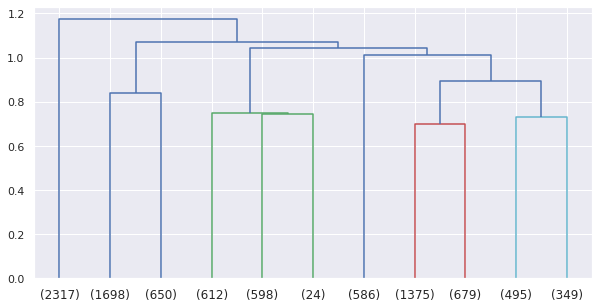

In [16]:
# %%flake8 # PEP8 compliance
# visualization of clustering
plt.figure(figsize=(10, 5))
mergings = linkage(X_std_s, method='average', metric='cosine')
dendrogram(mergings, truncate_mode='lastp', p=11)
plt.show()

#V. Evaluation

## V.i comparison of results

In [24]:
# %%flake8 # PEP8 compliance
# sumarize the result of models
i_db = np.nanargmax(score_db)
i_db2 = 14
i_H = np.argmax(score_H)
i_H2 = 42
d = {
    'KMeans': [4, score_K, gini_K, {'n_clusters': 4}],
    'DBSCAN_BestScore': [
                        n_clus_db[i_db], score_db[i_db], gini_db[i_db],
                        params_db[i_db]],
    'DBSCAN_Balance': [
                      n_clus_db[i_db2], score_db[i_db2], gini_db[i_db2],
                      params_db[i_db2]],
    'Hiera_BestScore': [
                       params_H[i_H]['n_clusters'], score_H[i_H], gini_H[i_H],
                       params_H[i_H]],
    'Hiera_Balance': [
                     params_H[i_H2]['n_clusters'], score_H[i_H2], gini_H[i_H2],
                     params_H[i_H2]]}

ev = pd.DataFrame(
    d, index=['n_cluster', 'score', 'gini', 'parameters']).transpose()
ev

,n_cluster,score,gini,parameters
KMeans,4,0.221558,0.299905,{'n_clusters': 4}
DBSCAN_BestScore,5,0.351458,0.79514,"{'eps': 1.7, 'min_samples': 6}"
DBSCAN_Balance,4,0.144599,0.394677,"{'eps': 1.0, 'min_samples': 49}"
Hiera_BestScore,4,0.797018,0.749627,"{'affinity': 'euclidean', 'linkage': 'single', 'n_clusters': 4}"
Hiera_Balance,4,0.178489,0.162768,"{'affinity': 'cosine', 'linkage': 'average', 'n_clusters': 4}"


##V.ii Interpretation of clusters
As shown in the evaluation table above, Kmeans give best sihouette score with a gini index acceptable. We'll try to interpret KMeans clustering.

In [7]:
X_std_s = pd.DataFrame(X_std).sample(frac=0.1, random_state=42)

In [8]:
from sklearn import manifold
tsne = manifold.TSNE(
            n_components=2,  # for projection in a plane
            perplexity=30,
            n_iter=300,
            init='pca',  # initialisation by a PCA
            random_state=0
        )
X_tsne = tsne.fit_transform(X_std_s)

In [20]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_pc)
cluster_K = kmeans.labels_
test = pd.Series(cluster_K).sample(frac=0.1, random_state=42)

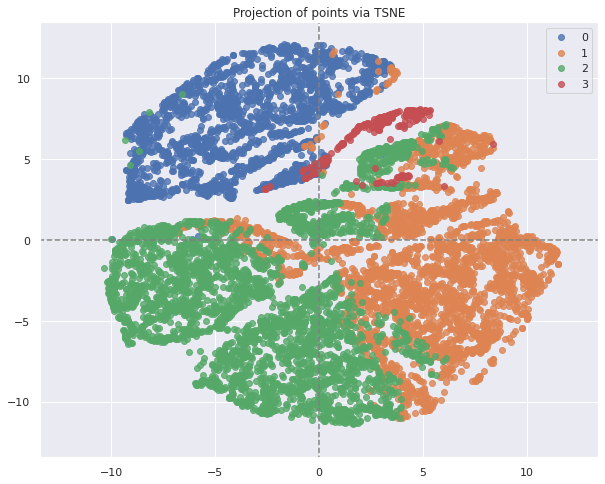

In [15]:
fc.display_factorial_planes(X_tsne, pca=None, axis_ranks=[(0, 1)], illustrative_var=test.values) 

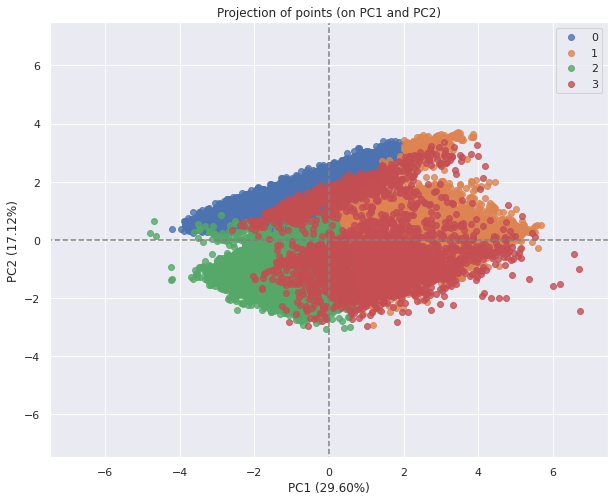

In [30]:
# %%flake8 # PEP8 compliance
# display KMeans clusters on factorial plane of PC1 and PC2
fc.display_factorial_planes(X_pc, pca, [(0, 1)], illustrative_var=cluster_K) 

In [21]:
# %%flake8 # PEP8 compliance
# observe kmeans cluster under all its features
data_K = data_cus.assign(Cluster=cluster_K)
gp = data_K.groupby('Cluster')
df = gp.mean().round(3)
# verify cluster's size
df.insert(0, 'size', gp.size())
df

,size,geolocation_lat,geolocation_lng,isSP,Recency,Frequency,Monetary,review_score,payment_installments,credit_card_pct,debit_card_pct,voucher_pct,product_weight_g,product_vol,order_item_number,air_conditioning,art,arts_and_craftmanship,audio,auto,baby,bed_bath_table,books_general_interest,books_imported,books_technical,cds_dvds_musicals,christmas_supplies,cine_photo,computers,computers_accessories,consoles_games,construction_tools_construction,construction_tools_lights,construction_tools_safety,cool_stuff,costruction_tools_garden,costruction_tools_tools,diapers_and_hygiene,drinks,dvds_blu_ray,electronics,fashio_female_clothing,fashion_bags_accessories,fashion_childrens_clothes,fashion_male_clothing,fashion_shoes,fashion_sport,fashion_underwear_beach,fixed_telephony,flowers,food,food_drink,furniture_bedroom,furniture_decor,furniture_living_room,furniture_mattress_and_upholstery,garden_tools,health_beauty,home_appliances,home_appliances_2,home_comfort_2,home_confort,home_construction,housewares,industry_commerce_and_business,kitchen_dining_laundry_garden_furniture,la_cuisine,luggage_accessories,market_place,music,musical_instruments,office_furniture,party_supplies,perfumery,pet_shop,security_and_services,signaling_and_security,small_appliances,small_appliances_home_oven_and_coffee,sports_leisure,stationery,tablets_printing_image,telephony,toys,watches_gifts
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,21811,-21.307,-46.425,0.421,248.263,1.021,104.793,4.117,1.004,0.013,0.064,0.111,1653.686,12604.241,1.093,0.003,0.003,0.0,0.005,0.043,0.028,0.095,0.006,0.001,0.003,0.0,0.001,0.001,0.001,0.095,0.013,0.007,0.003,0.002,0.037,0.002,0.001,0.000,0.003,0.001,0.034,0.001,0.024,0.0,0.001,0.002,0.000,0.002,0.003,0.000,0.006,0.003,0.001,0.076,0.004,0.000,0.046,0.094,0.007,0.002,0.000,0.004,0.004,0.061,0.003,0.003,0.0,0.009,0.004,0.0,0.007,0.016,0.001,0.033,0.019,0.0,0.002,0.006,0.000,0.088,0.024,0.001,0.053,0.038,0.052
1,32492,-21.023,-46.015,0.389,260.736,1.031,231.415,4.027,4.695,0.984,0.001,0.005,4310.204,29084.870,1.116,0.004,0.003,0.0,0.003,0.050,0.038,0.154,0.003,0.000,0.001,0.0,0.001,0.001,0.005,0.034,0.006,0.010,0.003,0.001,0.064,0.002,0.001,0.000,0.001,0.000,0.008,0.000,0.005,0.0,0.001,0.003,0.000,0.000,0.001,0.000,0.001,0.001,0.002,0.097,0.009,0.001,0.062,0.072,0.005,0.005,0.000,0.009,0.008,0.085,0.005,0.005,0.0,0.020,0.002,0.0,0.009,0.030,0.000,0.024,0.023,0.0,0.001,0.010,0.002,0.085,0.034,0.000,0.007,0.053,0.039
2,36742,-21.212,-46.129,0.445,224.522,1.017,72.815,4.168,2.395,0.996,0.000,0.003,452.304,4696.240,1.084,0.002,0.001,0.0,0.004,0.038,0.029,0.071,0.008,0.001,0.004,0.0,0.001,0.001,0.000,0.100,0.017,0.007,0.002,0.002,0.021,0.002,0.001,0.000,0.005,0.001,0.044,0.000,0.032,0.0,0.001,0.002,0.000,0.002,0.003,0.001,0.008,0.004,0.000,0.047,0.001,0.000,0.018,0.127,0.011,0.000,0.000,0.001,0.004,0.052,0.000,0.001,0.0,0.005,0.003,0.0,0.005,0.000,0.000,0.047,0.017,0.0,0.001,0.006,0.000,0.088,0.021,0.002,0.080,0.037,0.088
3,2783,-21.517,-46.453,0.440,235.191,1.411,323.107,3.549,3.731,0.731,0.011,0.022,2009.559,15415.495,3.875,0.008,0.003,0.0,0.003,0.095,0.055,0.502,0.010,0.000,0.001,0.0,0.008,0.003,0.007,0.339,0.015,0.065,0.023,0.011,0.052,0.010,0.001,0.005,0.032,0.002,0.056,0.003,0.066,0.0,0.006,0.005,0.002,0.002,0.014,0.000,0.021,0.017,0.005,0.641,0.029,0.000,0.238,0.211,0.012,0.002,0.001,0.015,0.038,0.343,0.008,0.006,0.0,0.014,0.010,0.0,0.014,0.135,0.000,0.056,0.061,0.0,0.019,0.010,0.000,0.258,0.043,0.001,0.070,0.063,0.117


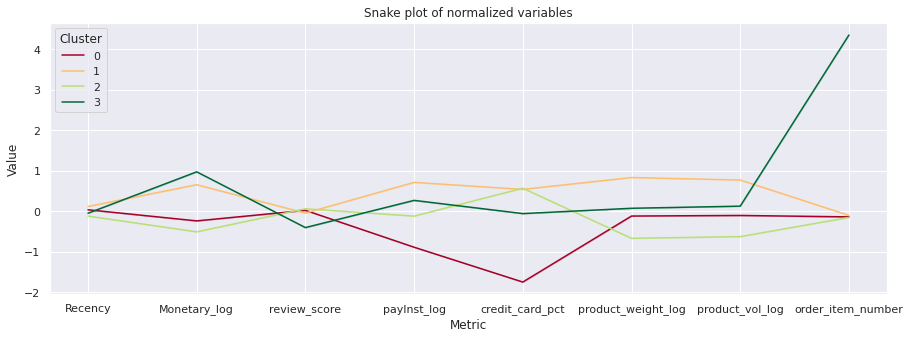

In [47]:
# %%flake8 # PEP8 compliance
# snake plot comparing features of different clusters
fc.snake_plot(X_std, cluster_K)

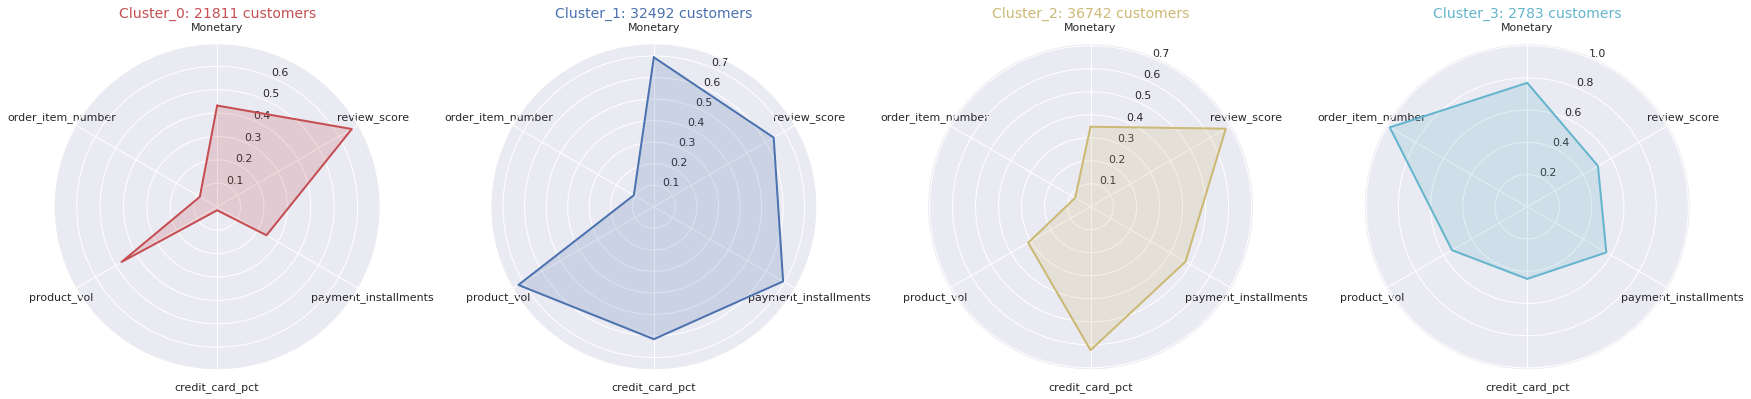

In [19]:
# customer profile
ls = [
      'Monetary', 'review_score', 'payment_installments', 'credit_card_pct',
      'product_vol', 'order_item_number']
scaler = QuantileTransformer()
data_cus_scaled = scaler.fit_transform(data_cus[ls])
data_scaled = pd.DataFrame(
    data_cus_scaled, columns=ls).assign(cluster=cluster_K)
fig, ax = plt.subplots(1, 4, figsize=(30, 6), subplot_kw=dict(polar=True))
for i, c in zip(range(4), ['r', 'b', 'y', 'c']):
    fc.radar_plot(data_scaled, vars=ls, label=i, color=c, ax=ax[i])

In [46]:
# %%flake8 # PEP8 compliance
# top 5 categories of products sold intra-cluster
df = pd.DataFrame()
for i in range(4):
    label = 'cluster '+str(i)
    df.insert(
        i, label,
        gp.mean().iloc[i, 14:].sort_values(ascending=False).head(5).index)

df.head()

,cluster 0,cluster 1,cluster 2,cluster 3
0,bed_bath_table,bed_bath_table,health_beauty,furniture_decor
1,computers_accessories,furniture_decor,computers_accessories,bed_bath_table
2,health_beauty,sports_leisure,watches_gifts,housewares
3,sports_leisure,housewares,sports_leisure,computers_accessories
4,furniture_decor,health_beauty,telephony,sports_leisure


This interpretation summarize features of each cluster. For each cluster, we suggest top sale products intra-cluster as mentioned above. Besides, we suggest products which are highlights **inter-cluster**, as metioned below. Words that reflect the characteristics of cluster are **bolded**:<br>

**Cluster 0**: (seems like young people or students without job)
1. tend to buy relatively **cheap** items. 
2. Not sensitive to product quality, usually giving positive reviews.
3. No installments, no credit card, mainly pay by **boleto**, likely to be stimulated by **vouchers**
4. Suggested products: books, food, fashion_clothings, party_supplies

**Cluster 1**: (2nd largest group, seems like people or family in medium consumption level)
1. Medium spending level
2. heavily rely on **credit** card and **installment** payments
3. tend to buy heavy and bulky products
4. Suggested products: air_conditioning, auto, baby, computer, cool_stuff, **furniture**_living_room,	furniture_mattress_and_upholstery, garden_tools, home_appliances, **home**_confort, houseware, luggage_accessories, **pet**_shop,small_appliances, toys.

**Cluster 2**: (1st largest group, seems like worked people in low consumption level)
1. tend to buy **cheap**, small and light items.
2. **active** recently
3. not sensitive to quality, usually giving positive reviews.
4. rely on **credit** card and partilly use installment payments
5. Suggested products: books, consoles_games, drinks, electronics, fashion, food, perfumery

**Cluster 3**: (best customer, seems like company or wealthy family)
1. **High consumption** level, rather active recently, high **frequency** and buy in **bulk**
2. Being **critical** in term of product reviews
3. tend to use credit card and boleto, slightly stimulated by vouchers, partially rely on installment payments.
4. Suggested products: auto, **baby**, chrismas_supplies, construction_tools, diapers_and_hygiene, drinks, food, fashion, **fixed_telephony**, garden_tools, health_beauty, **home**_appliances, home_confort, home_construction, **office**_furniture, perfumery, pet_shop, **signaling_and_security**, watches_gifts.







 

##V.iii Stability over time

In [12]:
# %%flake8 # PEP8 compliance
# import customer timestamp
path5 = dir+'/df_order.ft'
df_order = pd.read_feather(path5)
df_order['order_purchase_timestamp'] = pd.to_datetime(
    df_order['order_purchase_timestamp'])
# first purchase timestamp for unique customers
df = df_order[['order_purchase_timestamp', 'customer_unique_id']]
gp = df.groupby('customer_unique_id')['order_purchase_timestamp'].max()
data_tsp = pd.merge(gp, data_cus['customer_unique_id'],
                    on='customer_unique_id',
                    how='right')['order_purchase_timestamp']
# timestamp of the last purchase of each customer
data_tsp.head(3)

0   2018-05-10 10:56:27
1   2018-05-07 11:11:27
2   2017-03-10 21:05:03
Name: order_purchase_timestamp, dtype: datetime64[ns]

In [ ]:
# %%flake8 # PEP8 compliance
# import customer timestamp
def stability(X_pc=X_pc, freq=[30, 60, 90, 120, 150, 180], n=180):
    # initialization
    df_pc = pd.DataFrame(X_pc)
    model = KMeans(n_clusters=4, random_state=42)
    # set customers of first 180 days as reference
    end = data_tsp.min() + dt.timedelta(days=n)
    mask = (data_tsp < end)
    cus_init = df_pc[mask]
    model.fit(cus_init)
    old = model.labels_
    ARI = {}
    freq = freq
    # how often the system needs to be updated
    for freq_ in freq:
        shift = dt.timedelta(days=freq_)
        end = data_tsp.min() + dt.timedelta(days=n)
        ari = []
        i = 0
        # record upto 10 ARI score for each undate frequence
        while (i < 10) & (end <= data_tsp.max()):
            # add new customers
            end += shift
            mask_shift = (data_tsp < end)
            cus_shift = df_pc[mask_shift]
            # fit with new customers
            model.fit(cus_shift)
            new = model.labels_
            # compare labels of common customers
            ls = cus_init.index
            common_in_new = cus_shift.index.isin(ls)
            ari.append(adjusted_rand_score(old, new[common_in_new]))
            i += 1
        ARI[freq_] = ari
    return ARI

In [48]:
ARI = stability(freq=np.arange(30, 451, 30, dtype=np.float), n=180)
ARI

{30.0: [0.6891681901739406,
  0.9414575150641776,
  0.9257548850859731,
  0.9435947959218148,
  0.9380376935984472,
  0.9391405315362641,
  0.9337757567326622,
  0.9336033028957332,
  0.9204440869139427,
  0.91177684637323],
 60.0: [0.9414575150641776,
  0.9435947959218148,
  0.9391405315362641,
  0.9336033028957332,
  0.91177684637323,
  0.877719069375422,
  0.8669416069433307,
  0.8495945461466144,
  0.8183799442903122,
  0.8164593308984437],
 90.0: [0.9257548850859731,
  0.9391405315362641,
  0.9204440869139427,
  0.877719069375422,
  0.6716581280383457,
  0.8183799442903122,
  0.8164593308984437],
 120.0: [0.9435947959218148,
  0.9336033028957332,
  0.877719069375422,
  0.8495945461466144,
  0.8164593308984437],
 150.0: [0.9380376935984472,
  0.91177684637323,
  0.6716581280383457,
  0.8164593308984437],
 180.0: [0.9391405315362641,
  0.877719069375422,
  0.8183799442903122,
  0.8164593308984437],
 210.0: [0.9337757567326622, 0.8669416069433307, 0.8164593308984437],
 240.0: [0.9336

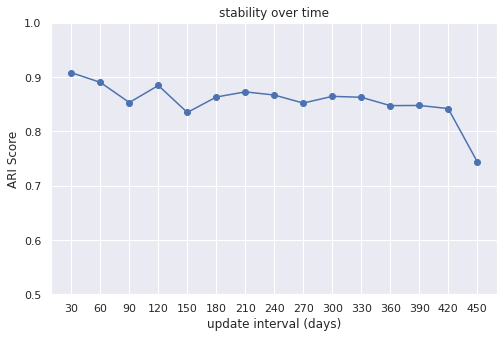

In [58]:
# visualization of stability over time
x =[]
y = []
for key, value in ARI.items():
    x.append(key)
    y.append(np.mean(value))

plt.figure(figsize=(8, 5))
plt.plot(x, y, '-o')
plt.xticks(np.arange(30, 451, 30))
plt.yticks(np.arange(0.5, 1.1, 0.1))
plt.ylim(0.5, 1)
plt.xlabel('update interval (days)')
plt.ylabel('ARI Score')
plt.title('stability over time')
plt.show()

The model present a stability robust. <br>
For a better stability, we suggest to update every 60 days. <br>
For a basic stability, we suggest to update every 14 months (420 days).

# Brouillon

In [ ]:
# search in a wide range of eps=(0,4) , n=(4,65)
# gradually narrow down to eps=(1.5, 1.7), n=(5,10)
eps = np.linspace(1.5, 1.7, 10)
min_samples = np.arange(5,10)
silt_score_db = pd.DataFrame()
n_clus_db = pd.DataFrame()
X = pd.DataFrame(X_pc).sample(frac=0.1, random_state=42)
#search optimal parameters by comparing n_clus, silhouette score and gini
for eps_ in eps:
  for n in min_samples:
    dbscan = DBSCAN(eps=eps_, min_samples=n,n_jobs=-1)
    dbscan.fit(X)
    n_clus=len(np.unique(dbscan.labels_))
    if (n_clus>3)&(n_clus<9):
      silt_score_db.loc[eps_,n] = silhouette_score(X, dbscan.labels_,
                                                   sample_size=5000)
      n_clus_db.loc[eps_,n] = len(np.unique(dbscan.labels_))
    else:
      silt_score_db.loc[eps_,n] = np.nan
      n_clus_db.loc[eps_,n] = len(np.unique(dbscan.labels_))

# display n_cluster and score under the corresponding parameters
df=silt_score_db.copy().round(4)
for i in range(silt_score_db.shape[1]):
  df.insert(2*i,'n_clus_'+str(i+min_samples.min()),n_clus_db.iloc[:,i])
df.index.name, df.columns.name ='eps','min_samples'
df

In [ ]:
# snake plot comparing features of different clusters
# cluster 1: customers of this cluster differ from others in geolocation while all other features are at an average level.
# This cluster makes no much sense for marketing, we'll remove geolocation features.
# if
sns.set_theme()
plt.figure(figsize=(20,5))
data_K_snake = data_noncat_std.assign(Cluster=cluster_K)
data_K_snake = pd.melt(data_K_snake, id_vars=['Cluster'],var_name='Metric')
plt.title('Snake plot of normalized variables')
plt.xlabel('Metric')
plt.ylabel('Value')
sns.lineplot(data=data_K_snake, x='Metric',y='value',hue='Cluster', 
             ci=0, palette='RdYlGn')
plt.show()

In [ ]:
silt_score={}
for k in range(3,11):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(data_noncat_std)
  silt_score[k]= silhouette_score(data_noncat_std,kmeans.labels_,
                                  random_state=42,sample_size=30000)
sns.pointplot(x=list(silt_score.keys()),y=list(silt_score.values()))
plt.show()

In [ ]:
fc.display_factorial_planes(pcs,8,pca,[(0,1)],illustrative_var=RFMLabel['RFMSegment'],alpha=0.3) 

In [ ]:
fc.display_factorial_planes(pcs,8,pca,[(0,1)],illustrative_var=RFMLabel['RFMLevel'],alpha=0.3) 

In [37]:
def shift_stability(freq=[15, 30, 60, 90, 120], n=180):
    # initialization
    df_pc = pd.DataFrame(X_pc)
    model = KMeans(n_clusters=4, random_state=42)
    ARI = {}
    N = n
    freq = freq
    # how often the system needs to be updated
    for freq_ in freq:
        shift = dt.timedelta(days=freq_)
        ari = []
        # Suppose that Olist only analyse customers who have spent money in 
        # last n days
        n = N
        start = data_tsp.min()
        end = data_tsp.min() + dt.timedelta(days=N)
        i=0
        # record upto 10 ARI score for each undate frequence
        while (i < 10) & (end <= data_tsp.max()):
            mask = (data_tsp >= start) & (data_tsp < end)
            cus_init = df_pc[mask]
            model.fit(cus_init)
            old = model.labels_
            # shift time interval
            start += shift
            end += shift
            # index after shift
            mask_shift = (data_tsp >= start) & (data_tsp < end)
            cus_shift = df_pc[mask_shift]
            model.fit(cus_shift)
            new = model.labels_
            # compare
            common = mask & mask_shift
            ls = common[common].index
            common_in_old = cus_init.index.isin(ls)
            common_in_new = cus_shift.index.isin(ls)
            ari.append(adjusted_rand_score(old[common_in_old], new[common_in_new]))
            i+=1
        ARI[freq_]=ari
    return ARI

In [38]:
ARI1 = shift_stability(freq=np.arange(30,130,30,dtype=np.float),n=100)

In [42]:
ARI1

{30.0: [0.8582183038073428,
  0.53541263214908,
  0.5859634658887543,
  0.9393918836311973,
  0.7252366927737133,
  0.6828008498199726,
  0.6963624641827019,
  0.7128729631182347,
  0.8718325750356092,
  0.9956761040519028],
 60.0: [1.0,
  0.6284351912677252,
  0.8669193029332963,
  0.94402237114084,
  0.8646274007443143,
  0.9647584543328916,
  0.6756034558911829,
  0.7911372688840392,
  0.6784057016613932,
  0.9454143869295866],
 90.0: [1.0,
  0.8406043074633842,
  0.844364334913513,
  0.963597619948322,
  0.6866693523051804,
  0.5620560509482002,
  0.8841207890310424],
 120.0: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

<ErrorbarContainer object of 3 artists>

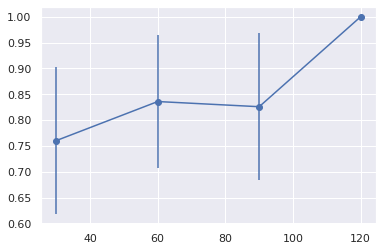

In [39]:
# when freq > n, the shift dimension is larger than data itself, so there is no
# common part between label before & after. That's why ARI = 1
x =[]
y1 = []
y2 = []
for key, value in ARI1.items():
    x.append(key)
    y1.append(np.mean(value))
    y2.append(np.std(value))

plt.errorbar(x,y1,y2, fmt='-o')